In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras_hub
import numpy as np

from keras import layers
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import tensorflow as tf

# Data
BATCH_SIZE = 128
SEQ_LEN = 128  # Length of training sequences, in tokens
MAX_SEQ = 3000
MIN_LEN = 35

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 128
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 3000  # Limits parameters in model.

# Training
EPOCHS = 15
USE_DATASETS = True
LEARN_RATE = 0.01

# Inference
NUM_TOKENS_TO_GENERATE = 20

SAMP = 7

LARGER_TRAIN = False
if LARGER_TRAIN:
  BATCH_SIZE = 512
  EPOCHS = 50

import keras 
!pip install keras_hub
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Check saved weights
weight_url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/simple_generative_weights_1.keras"
use_old_weights = True
have_old_weights = False
try:
  old_weights = keras.utils.get_file('simple_generative_weights_1.keras', weight_url)
  have_old_weights = True
except:
  print("No old weights found.")
  pass



/Users/akeem/anaconda3/envs/tf_mar_2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Text Generation with LSTM

As we have seen, LSTM models are excellent at dealing with sequential data. As luck would have it, text is also sequental data! We can train a model to predict the next word in a sentence, then use that smarts to generate new text. Basically ChatGPT, but far better. 

### Text for Training

We need some text from which to train our model to speak, I captured a small extract of text from Reddit posts, which vaguely resembles actual language, if that language is filtered through a bucket of social isolation, Adderall, racism, and memes. We'll first need to clean up our data a bit before we can assemble it for modelling. The initial cleaning bits are just like what we used in NLP, we just need to get rid of all the junk. 

We can use pretty much anything that you can imagine as source, and assuming we can gather enough data and train our model, the generated speech will be styled after the source. I liken it to going on vacation in Indonesia and talking to Indonesians who spoke English like Australian surfer bros - their training data was a little weird, so the output was a little weird too. If you're looking to build your best ChatGPT competitor you will want a lot of data, specifically a lot of data that is representative of the full gamut of how you want your model to write. If you want slang in the new text, you can't really train on Shakespeare and Wikipedia.

In [2]:
# Complaint data
USE_REDDIT = True
if USE_REDDIT:
    # Reddit WSB data
    train_text_file = keras.utils.get_file('train_text.txt', 'https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/reddit_wsb.csv')
    USE_COL = "body"
    train_text = pd.read_csv(train_text_file)
    train_text[USE_COL] = train_text['title'].astype("str") + " " + train_text[USE_COL].astype("str")
    train_text[USE_COL] = train_text[USE_COL].str.replace("\n", " ")
    #clean punctuation
    train_text[USE_COL] = train_text[USE_COL].str.replace("[^\w\s]", "")
    train_text[USE_COL].dropna(inplace=True)
else:
    # Complaint data
    train_text_file = keras.utils.get_file('train_text.txt', 'https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/complaints_processed_clean.csv')
    USE_COL = "narrative"
    train_text = pd.read_csv(train_text_file)
    train_text[USE_COL] = train_text[USE_COL].astype("str")


print(np.mean(len(train_text[USE_COL])))
train_text.sample(10)

<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/var/folders/p1/m8wtcgx57417hx9d_r110ctw0000gn/T/ipykernel_80047/1458716329.py:11: SyntaxWarning: invalid escape sequence '\w'
  train_text[USE_COL] = train_text[USE_COL].str.replace("[^\w\s]", "")


43732027/43732027 ━━━━━━━━━━━━━━━━━━━━ 106s 2us/step
53187.0


,title,score,id,url,comms_num,created,body,timestamp
823,"Ladies and gentlemen, we got 'em.",14,l6wxb8,https://i.redd.it/d3ivm0vpu2e61.jpg,0,1.611870e+09,"Ladies and gentlemen, we got 'em. nan",2021-01-28 23:44:29
24119,I still can’t stop buying💎🙌🏾🚀🚀🚀,165,lbrk69,https://i.redd.it/q2h4iqfmiaf61.jpg,5,1.612399e+09,I still can’t stop buying💎🙌🏾🚀🚀🚀 nan,2021-02-04 02:35:05
26176,"Got 2 whole GME, a bunch of NOK, Socks for Lis...",6,lcmghj,https://i.redd.it/y3qfs3vr8if61.jpg,1,1.612492e+09,"Got 2 whole GME, a bunch of NOK, Socks for Lis...",2021-02-05 04:34:08
45677,CRSR earnings next week... pls fly - got $70k ...,46,mzs4iy,https://i.redd.it/59sok8parqv61.jpg,30,1.619569e+09,CRSR earnings next week... pls fly - got $70k ...,2021-04-28 03:18:21
45659,MindMed on CNN. People are slowly realizing th...,10853,mzubm7,https://v.redd.it/w0g60exj7rv61,1193,1.619575e+09,MindMed on CNN. People are slowly realizing th...,2021-04-28 04:52:43
51895,"Ride the Magic ShortBus TA DD - SPY, AMC, SPCE...",47,okcjtr,https://www.reddit.com/r/wallstreetbets/commen...,35,1.626322e+09,"Ride the Magic ShortBus TA DD - SPY, AMC, SPCE...",2021-07-15 07:11:07
44675,"More PLTR, can’t wait for next Wednesday",141,mnhm8i,https://i.redd.it/rhar63aek5s61.jpg,50,1.618005e+09,"More PLTR, can’t wait for next Wednesday nan",2021-04-10 00:49:54
36601,🐸🐸 JFrog $FROG DD - A great software company w...,5,lu46g7,https://www.reddit.com/r/wallstreetbets/commen...,40,1.614511e+09,🐸🐸 JFrog $FROG DD - A great software company w...,2021-02-28 13:20:57
1378,Robin Hood can’t stop us!,3,l6ywmv,https://i.redd.it/5os6myxi83e61.jpg,0,1.611875e+09,Robin Hood can’t stop us! nan,2021-01-29 01:01:53
8541,Squeezed out,1,l70kcs,https://www.reddit.com/r/wallstreetbets/commen...,0,1.611878e+09,Squeezed out Couldn't get the shares yesterday...,2021-01-29 01:59:56


<b>Note:</b> the install of the NLTK stuff can be weird on Colab. Sometimes I need to run it, let it install, and run again. On my laptop, it works normally, I beleive it is just due to the temporary virtual environment on Colab. 

In [3]:
try:
    import nltk
except ImportError:
    !pip install nltk
    import nltk
    nltk.download('punkt_tab')

tokenizer_simple = nltk.tokenize.word_tokenize
try:
  tokenized_text = train_text[USE_COL].apply(tokenizer_simple)
except:
  nltk.download('punkt_tab')
  tokenized_text = train_text[USE_COL].apply(tokenizer_simple)

tokenized_text = tokenized_text.apply(lambda x: [word.lower() for word in x])
sample_tok = tokenized_text[SAMP]
print("Sample:")
print("\tDimensions:", len(sample_tok))
print("\tSample:", sample_tok)


Sample:
	Dimensions: 428
	Sample: ['this', 'is', 'the', 'moment', 'life', 'is', "n't", 'fair', '.', 'my', 'mother', 'always', 'told', 'me', 'that', 'when', 'i', 'would', 'complain', 'about', 'arbitrary', 'treatment', '.', 'i', 'would', 'play', 'by', 'the', 'rules', 'and', 'someone', 'else', 'would', 'ignore', 'them', '.', 'when', 'they', 'would', 'win', 'i', 'would', 'appeal', 'to', 'the', 'first', 'authority', 'for', 'an', 'explanation', '.', '``', 'are', 'you', 'going', 'to', 'let', 'them', 'get', 'away', 'with', 'this', "''", '?', '``', 'life', 'is', "n't", 'fair', "''", '.', 'no', ',', 'it', 'is', 'not', '.', 'the', 'game', 'is', 'the', 'game', '.', 'always', '.', 'in', 'this', 'moment', ',', 'the', 'fascade', 'cracks', 'further', '.', 'when', 'the', 'first', 'breach', 'was', 'made', 'i', 'do', 'not', 'know', ',', 'perhaps', 'it', 'was', 'socrates', ',', 'but', 'today', 'i', 'see', 'thousands', '.', 'millions', '.', 'once', 'they', 'were', 'laughing', ',', 'luxuries', 'falling', 'o

## Data Processing Functions

### Vectorization

In [4]:
class SimpleVectorizer():
    def __init__(self, max_tokens):
        self.max_tokens = max_tokens
        self.vocab = {}
        self.reverse_vocab = {}
    def fit_on_texts(self, texts):
        self.vocab = {word: i+1 for i, word in enumerate(set([word for text in texts for word in text]))}
        self.reverse_vocab = {i: word for word, i in self.vocab.items()}
        #limit to max tokens
        tokens_to_keep = list(self.vocab.keys())[:self.max_tokens]
        self.vocab = {word: i+1 for i, word in enumerate(tokens_to_keep)}
        self.reverse_vocab = {i: word for word, i in self.vocab.items()}
    def texts_to_sequences(self, texts):
        return [[self.vocab[word] for word in text if word in self.vocab] for text in texts]            

### Construct Training Sequences

We are going to be a little slack in the construction of the datasets for training because we are limited in the amount of resources we can handle. All of the datasets that are fed to the model need to be the same length, so we'll set a cap and trucate it here for resource concerns. Our dataset will be constructed as:
<ul>
<li> A sequence of (up to) 24 words as the X data. 
<li> The next word as the Y data.
</ul>

So each sequence is effectively one set of features, and its target is the next word. If we were doing this in reality, we'd want to prep more records from our sample:
<ul>
<li> Suppose a sample sentence is "The quick brown fox jumps over the lazy dog". Our ideal data would have something like:
    <ul> 
    <li>X = "the quick brown", Y = "fox"
    <li> X = "quick brown fox", Y = "jumps"
    <li> X = "brown fox jumps", Y = "over"
    </ul>
</ul>

This is superior both because we are generating much more data to train the model and because we are training the model to predict words in all different positions in the sentence. We'd be predicting almost every word in the training dataset. The words that frequently end a sentence are not necessarily the same as the words that start a sentence or sit in the middle, so making predictions up and down the text will likely lead to a more useful model.

<b>We'd end up with a better model if we generated more sequences from our data and/or added more data. The resource demands make that tough, so we have cut some corners that are easy to remedy in a real-world scenario.</b>

In [5]:
def construct_input_sequences(data, seq_length, max_sequences, max_per_doc=5):
    input_sequences = []
    while len(input_sequences) < max_sequences:
        for doc in data:
            sequences_for_doc = []
            num_sequence_for_doc = 0
            for i in range(len(doc) - seq_length):
                if num_sequence_for_doc < max_per_doc:
                    sequences_for_doc.append(doc[i:i + seq_length])
                    num_sequence_for_doc += 1
                else:
                    break
            input_sequences.extend(sequences_for_doc)
    
    return input_sequences
input_sequences = construct_input_sequences(tokenized_text, SEQ_LEN, MAX_SEQ)
print(input_sequences[SAMP])


['does', "n't", 'have', 'an', 'expiration', 'date', 'hedgefund', 'whales', 'are', 'spreading', 'disinfo', 'saying', 'friday', 'is', 'make-or-break', 'for', '$', 'gme', '.', 'call', 'options', 'expiring', 'itm', 'on', 'friday', 'will', 'drive', 'the', 'price', 'up', 'if', 'levels', 'are', 'maintained', ',', 'but', 'may', 'not', 'trigger', 'the', 'short', 'squeeze', '.', 'it', 'may', 'be', 'friday', ',', 'but', 'it', 'could', 'be', 'next', 'week', 'the', 'we', 'see', 'the', 'real', 'squeeze', '.', 'do', "n't", 'panic', 'if', 'the', 'squeeze', 'does', "n't", 'happen', 'friday', '.', 'it', "'s", 'not', 'guaranteed', 'to', '.', 'the', 'only', 'thing', 'that', 'is', 'guaranteed', 'mathematically', 'is', 'that', 'the', 'shorts', 'will', 'have', 'to', 'cover', 'at', 'some', 'point', 'in', 'the', 'future', '.', 'they', 'are', 'trying', 'to', 'get', 'enough', 'people', 'hooked', 'on', 'the', 'false', 'expectation', 'of', 'friday', 'so', 'that', 'if/when', 'it', 'does', "n't", 'happen', ',', 'eno

### Vectorize

We can take our tokenized data and convert it to a vector. 

In [6]:
vect_sequences = SimpleVectorizer(max_tokens=VOCAB_SIZE)
vect_sequences.fit_on_texts(input_sequences)
tokenized_sequences = vect_sequences.texts_to_sequences(input_sequences)
SAMP = np.random.randint(0, len(tokenized_sequences))
sample_tok = tokenized_sequences[SAMP]
print("Sample:")
print("\tDimensions:", len(sample_tok))
print("\tSample:", sample_tok)
print("\tSample text:", vect_sequences.reverse_vocab[sample_tok[0]])

Sample:
	Dimensions: 5
	Sample: [1461, 265, 65, 65, 2391]
	Sample text: was


### Pad Sequences

We need to pad our sequences so that they are all the same length. This is a requirement of the LSTM model. Note that we want the padding at the start of the sequence, not the end. This is because we are trying to predict the next word in the sequence, so we want the model to see the words that come before it. If we pad at the end, the model will not be able to see the words that come before it.

In [7]:
from keras.utils import pad_sequences
padded_sequences = pad_sequences(tokenized_sequences, maxlen=SEQ_LEN, padding='pre', truncating='post')
print("Dimensions:", padded_sequences.shape)
print("type:", type(padded_sequences))
padded_input_sequences = padded_sequences

X_t = padded_input_sequences[:, :-1]
Y_t = padded_input_sequences[:, -1].ravel()
print("X_t shape:", X_t.shape)
print("Y_t shape:", Y_t.shape)

Dimensions: (59017, 128)
type: <class 'numpy.ndarray'>
X_t shape: (59017, 127)
Y_t shape: (59017,)


In [8]:
sample_x_record = X_t[SAMP]
sample_y_record = Y_t[SAMP]
print("X:", sample_x_record)
print("Y:", sample_y_record)
print("X shape:", sample_x_record.shape)
print("Y shape:", sample_y_record.shape)

X: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 1461  265   65
   65]
Y: 2391
X shape: (127,)
Y shape: ()


In [9]:
weight_save_callback = keras.callbacks.ModelCheckpoint(
    filepath='simple_generative_weights_1.keras',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

Epoch 1/15


2025-04-15 16:20:19.702922: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-15 16:20:19.703063: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-15 16:20:19.703068: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1744755619.703642  908801 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744755619.704012  908801 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-15 16:20:20.506501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0715 - loss: nan
Epoch 1: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 48s 142ms/step - accuracy: 0.0714 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0000e+00 - loss: nan
Epoch 2: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0000e+00 - loss: nan
Epoch 3: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.0000e+00 - loss: nan
Epoch 4: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/15
323/323 

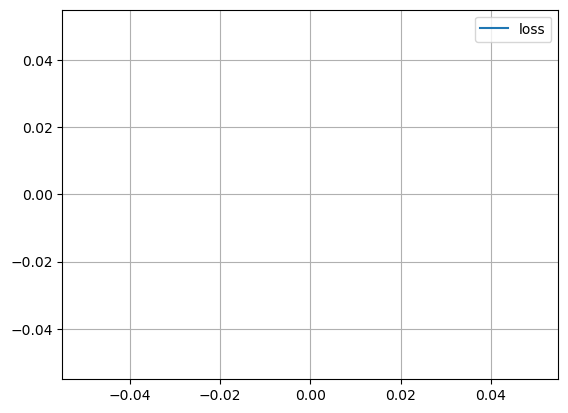

In [10]:
try:
  del tokenized_sequences, tokenized_text, input_sequences
except:
  pass

# Build model
model = keras.Sequential()
model.add(layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(layers.LSTM(EMBED_DIM, return_sequences=True))
model.add(layers.LSTM(EMBED_DIM))
model.add(layers.Dense(EMBED_DIM, activation='relu'))
model.add(layers.Dense(VOCAB_SIZE, activation='softmax'))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Print model summary
# Train model
history = model.fit(
    X_t, 
    Y_t,
    #train_ds_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_split=0.3,
    callbacks=[weight_save_callback],
)
plot_loss(history)

### Generate Some Text

We can generate text once the model is trained. We'll start with a seed sentence, and then we'll use the model to predict the next word. We'll then append that word to the sentence and use the model to predict the next word, and so on. There is a little helper function to do this for us with limited repetition.

Another new thing is that we create an inverse dictionary to map the encoded words back to the original words.

### Temperature

One weirdly named factor that is important in text generation is the temperature. The temperature is a factor that we can use to control the randomness of the output. To generate text, we are essentially using a probability distribution to determine what the next word should be - the softmax output of the model will tell us the most likely next word. The issue is that certain words are way more likely than others - "the", "it", "a", "and", etc. are all very common words so we can expect the model to predict them as "most likely" a lot, probably too often. 

![Temperature](images/temperature.gif "Temperature")

The most direct way to combat this is to add some degree of randomness to which word we select - we'll still pick the most likely word more often than any other, but we'll also pick other words that have some degree of likelihood at random. The higher the temperature the more randomness is introduced. A correct value requires tuning with human feedback, and it'll vary depending on the base quality of the model - large models that are trained on huge volumes of text and are deep enough to pick up on the "what type of word should be here" patterns will be able to generate better text with lower temperatures. Our model here is small and kind of sucks, so the temperature needs to be higher to get anything remotely usable. The implementation here is stolen shamelessly from the internet, the details don't really matter all that much, we just need to vary our predictions away from always simply picking the most likely word.

In [11]:
from random import *
import string
import re
def text_to_word_sequence(text):
    text = text.lower()
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    seq = text.split()
    return seq
def sampleWord(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds.flatten(), 1)
    return np.argmax(probas)

def gen_text(seed_text, next_words, model, length_max, tok, inverse, temperature=1.0, check_in_vocab=True):
    out = seed_text
    for _ in range(next_words):
        token_list = tok.texts_to_sequences([out])[0]
        if check_in_vocab:
            for tok_n in token_list:
                if tok_n not in tok.vocab.values():
                    token_list.remove(tok_n)
        token_list = pad_sequences([token_list], maxlen=length_max-1, padding='pre')
        #print(token_list)
        predicted = model.predict(token_list, verbose=0)
        #print(tok.sequences_to_texts(predicted))
        word=""
        try:
            word = inverse[sampleWord(predicted, temperature=temperature)]
        except:
            pass
        out += " "+word
        #print(out)
    return out

#### Fake Text Time!

<b>Note: we haven't built in any error handling, so it is possible to get random errors with unknown seeds. </b> In the real world, parsing the inputs from the user would be a more serious task, but for this example, we can just ignore it.

In [12]:
seed_text_1 = "The customer service was the best thing I've ever seen, now I love this company and want to buy all their products. No other store will ever do it for me after this experience."
seed_text_2 = "I would like to complain about"
seed_text_3 = "Based crypto lit awesome subreddit bruh. I love this place, it's so sick and tight"

output_1 = gen_text(seed_text_1, NUM_TOKENS_TO_GENERATE, model, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
output_2 = gen_text(seed_text_2, NUM_TOKENS_TO_GENERATE, model, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
output_3 = gen_text(seed_text_3, NUM_TOKENS_TO_GENERATE, model, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
print("Seed text:", seed_text_1)
print("Generated text:", output_1)
print("Seed text:", seed_text_2)
print("Generated text:", output_2)
print("Seed text:", seed_text_3)
print("Generated text:", output_3)

Seed text: The customer service was the best thing I've ever seen, now I love this company and want to buy all their products. No other store will ever do it for me after this experience.
Generated text: The customer service was the best thing I've ever seen, now I love this company and want to buy all their products. No other store will ever do it for me after this experience.                    
Seed text: I would like to complain about
Generated text: I would like to complain about                    
Seed text: Based crypto lit awesome subreddit bruh. I love this place, it's so sick and tight
Generated text: Based crypto lit awesome subreddit bruh. I love this place, it's so sick and tight                    


### Use Old Weights

I've run several rounds of training this model, and I've posted the weights online. The code here will load it, so we can expect our results to be a bit more logical here. 

<b>Note:</b> On the whole, our training process - in terms of data, time, and model size, is very tiny. Real text generation models are orders of magnitude larger, so don't expect much. 

##### Callback Example

We can also generate text at the end of each epoch using a callback. Here we will print it, but it could also be logged to any location, such as the tensorboard logs. This is a good example of a simple, custom callback. We could bulk this out a little by creating a full class if we needed, and allow for things like multiple seeds, multiple generations, logging only every N epochs, etc... that's a good exercsie. 

In [13]:
callback_seed_text = "We're off to see the wizard, the wonderful wizard of"
gen_text_callback = keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print("\nGenerated text after epoch {}: {}\n".format(epoch, gen_text(callback_seed_text, NUM_TOKENS_TO_GENERATE, model, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)))
)

if have_old_weights and use_old_weights:
    print("Loading old weights.")
    try:
      model.load_weights(old_weights)
      print("Old weights loaded.")
    except:
      print("Error loading old weights.")
      pass
else:
    print("No old weights found, starting from scratch.")

model.fit(
    X_t, 
    Y_t,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_split=0.3,
    callbacks=[gen_text_callback, weight_save_callback],
)

Loading old weights.
Old weights loaded.
Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.0000e+00 - loss: nan
Generated text after epoch 0: We're off to see the wizard, the wonderful wizard of                    


Epoch 1: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.0000e+00 - loss: nan
Generated text after epoch 1: We're off to see the wizard, the wonderful wizard of                    


Epoch 2: loss did not improve from inf
323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0000e+00 - loss: nan
Generated text after epoch 2: We're off to see the wizard, the wonderful wizard of                    


Epoch 3: loss did not improve from inf
323/323 ━━━━━━━━

### Larger Model with Bi-Directional LSTM

We can also build a larger model with a bi-directional LSTM. This is a more complex model that will take longer to train, but it should be able to generate better text. The bi-directional LSTM will look at the text in both directions, which should help it understand the context of the words better.

In [14]:
model_bi = keras.Sequential()
model_bi.add(layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))

model_bi.add(layers.Bidirectional(layers.LSTM(EMBED_DIM, return_sequences=True)))
model_bi.add(layers.Bidirectional(layers.LSTM(EMBED_DIM)))
model_bi.add(layers.Dense(EMBED_DIM, activation='relu'))
model_bi.add(layers.Dense(VOCAB_SIZE, activation='softmax'))
model_bi.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history_bi = model_bi.fit(
    X_t, 
    Y_t,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_split=0.3,
    callbacks=[gen_text_callback]
)

Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1506 - loss: 6.6340
Generated text after epoch 0: We're off to see the wizard, the wonderful wizard of                    

323/323 ━━━━━━━━━━━━━━━━━━━━ 193s 589ms/step - accuracy: 0.1507 - loss: 6.6333 - val_accuracy: 0.1645 - val_loss: 11.3954
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1630 - loss: 7.2029
Generated text after epoch 1: We're off to see the wizard, the wonderful wizard of                    

323/323 ━━━━━━━━━━━━━━━━━━━━ 190s 588ms/step - accuracy: 0.1630 - loss: 7.2022 - val_accuracy: 0.1734 - val_loss: 9.9045
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.1827 - loss: 6.3051
Generated text after epoch 2: We're off to see the wizard, the wonderful wizard of                    

323/323 ━━━━━━━━━━━━━━━━━━━━ 241s 746ms/step - accuracy: 0.1827 - loss: 6.3062 - val_accuracy: 0.1795 - val_loss: 10.9558
Epoch 4/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - acc

In [15]:
output_1 = gen_text(seed_text_1, NUM_TOKENS_TO_GENERATE, model_bi, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
output_2 = gen_text(seed_text_2, NUM_TOKENS_TO_GENERATE, model_bi, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
output_3 = gen_text(seed_text_3, NUM_TOKENS_TO_GENERATE, model_bi, SEQ_LEN, vect_sequences, vect_sequences.reverse_vocab)
print("Seed text:", seed_text_1)
print("Generated text:", output_1)
print("Seed text:", seed_text_2)
print("Generated text:", output_2)
print("Seed text:", seed_text_3)
print("Generated text:", output_3)

Seed text: The customer service was the best thing I've ever seen, now I love this company and want to buy all their products. No other store will ever do it for me after this experience.
Generated text: The customer service was the best thing I've ever seen, now I love this company and want to buy all their products. No other store will ever do it for me after this experience.                    
Seed text: I would like to complain about
Generated text: I would like to complain about                    
Seed text: Based crypto lit awesome subreddit bruh. I love this place, it's so sick and tight
Generated text: Based crypto lit awesome subreddit bruh. I love this place, it's so sick and tight                    


## Exercise - Create Generative Model

Grab some text, try it. There are a bunch in the keras datasets, or on Kaggle. 

The core approach can be very similar for any column of data. You can also try other details, notably some parts that we did manually can be done more directly with some keras functions. 

In [16]:
# Get Text Data

sample_example_text = keras.datasets.reuters.load_data()
reuters_tokenizer = keras.datasets.reuters.get_word_index()
inverse_reuters_tokenizer = {v: k for k, v in reuters_tokenizer.items()}

def index_to_word(index):
    return str(reuters_tokenizer[index])

# preview 5 records
sample_example_text = sample_example_text[0][0][:5]
print("Sample example text:")
for i in range(5):
    as_text = [inverse_reuters_tokenizer.get(x, x) for x in sample_example_text[i]]
    indicies = np.array(sample_example_text[i])
    print("\tTokens:\n", sample_example_text[i])
    print("\tText:\n", as_text)
print("Sample example text shape:", sample_example_text.shape)
sample_example_text = sample_example_text[0]

Sample example text:
	Tokens:
 [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
	Text:
 ['the', 'wattie', 'nondiscriminatory', 'mln', 'loss', 'for', 'plc', 'said', 'at', 'only', 'ended', 'said', 'commonwealth', 'could', '1', 'traders', 'now', 'april', '0', 'a', 'after', 'said', 'from', '1985', 'and', 'from', 'foreign', '000', 'april', '0', 'prices', 'its', 'account', 'year', 'a', 'but', 'in', 'this', 'mln', 'home', 'an', 'states', 'earlier', 'and', 'rise', 'and', 'revs', 'vs', '000', 'its', '16', 'vs', '000', 'a', 'but', '3', 'psbr', 'oils', 'several', 'and', 'shareholders', 'and', 'dividend', 'vs', '000', 'its', 'all', '4', 'vs', '000', '1', 'mln', 'agreed', 'largely', 'ap